In [1]:
# first some necessary python imports
import numpy as np
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from models import WilkensLET

## SHIELD-HIT12A LET calculations

### Pencil beam simulation

 - Energy: 60 MeV
 - Energy spread: 0.5 MeV
 - Point-like source in vacuum
 - Cylindrical liquid water target (R=10cm, L=4cm)
 - DELTAE = 0.005
 - scoring dLET for protons only (the newer, better one) in cylindrical slabs 0.1mm thick (400 slabs on 4cm) of various radius
 - 10^8 particles

In [2]:
# let's load SH12A data
l1 = np.loadtxt("pencil/dlet_cyl1.dat")
l2 = np.loadtxt("pencil/dlet_cyl0p1.dat")
l3 = np.loadtxt("pencil/dlet_cyl0p01.dat")
l4 = np.loadtxt("pencil/dlet_cyl0p001.dat")

al1 = np.loadtxt("pencil/adlet_cyl1.dat")
al2 = np.loadtxt("pencil/adlet_cyl0p1.dat")
al3 = np.loadtxt("pencil/adlet_cyl0p01.dat")
al4 = np.loadtxt("pencil/adlet_cyl0p001.dat")

In [3]:
# let's calculate dLETp from Wilkens model
E_MeV = 60
sigma_E_MeV = 0.5
dlet_keV_um = WilkensLET.let_d_keV_um(E_MeV, sigma_E_MeV, l1[:,0])
tlet_keV_um = WilkensLET.let_t_keV_um(E_MeV, sigma_E_MeV, l1[:,0])

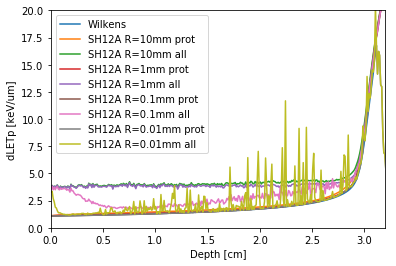

In [4]:
plt.plot(l1[:,0], dlet_keV_um, label="Wilkens")
plt.plot(l1[:,0],l1[:,1], label="SH12A R=10mm prot")
plt.plot(al1[:,0],al1[:,1], label="SH12A R=10mm all")
plt.plot(l2[:,0],l2[:,1], label="SH12A R=1mm prot")
plt.plot(al2[:,0],al2[:,1], label="SH12A R=1mm all")
plt.plot(l3[:,0],l3[:,1], label="SH12A R=0.1mm prot")
plt.plot(al3[:,0],al3[:,1], label="SH12A R=0.1mm all")
plt.plot(l4[:,0],l4[:,1], label="SH12A R=0.01mm prot")
plt.plot(al4[:,0],al4[:,1], label="SH12A R=0.01mm all")
plt.xlabel("Depth [cm]")
plt.ylabel("dLETp [keV/um]")
plt.ylim(0,20)
plt.xlim(0,3.2)
plt.legend(loc=0)

In [5]:
# let's load SH12A data
t1 = np.loadtxt("pencil/tlet_cyl1.dat")
t2 = np.loadtxt("pencil/tlet_cyl0p1.dat")
t3 = np.loadtxt("pencil/tlet_cyl0p01.dat")
t4 = np.loadtxt("pencil/tlet_cyl0p001.dat")

at1 = np.loadtxt("pencil/atlet_cyl1.dat")
at2 = np.loadtxt("pencil/atlet_cyl0p1.dat")
at3 = np.loadtxt("pencil/atlet_cyl0p01.dat")
at4 = np.loadtxt("pencil/atlet_cyl0p001.dat")

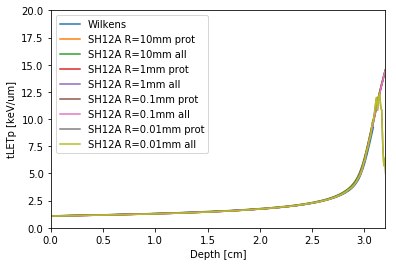

In [6]:
plt.plot(t1[:,0], tlet_keV_um, label="Wilkens")
plt.plot(t1[:,0],t1[:,1], label="SH12A R=10mm prot")
plt.plot(at1[:,0],at1[:,1], label="SH12A R=10mm all")
plt.plot(t2[:,0],t2[:,1], label="SH12A R=1mm prot")
plt.plot(at2[:,0],at2[:,1], label="SH12A R=1mm all")
plt.plot(t3[:,0],t3[:,1], label="SH12A R=0.1mm prot")
plt.plot(at3[:,0],at3[:,1], label="SH12A R=0.1mm all")
plt.plot(t4[:,0],t4[:,1], label="SH12A R=0.01mm prot")
plt.plot(at4[:,0],at4[:,1], label="SH12A R=0.01mm all")
plt.xlabel("Depth [cm]")
plt.ylabel("tLETp [keV/um]")
plt.ylim(0,20)
plt.xlim(0,3.2)
plt.legend(loc=0)

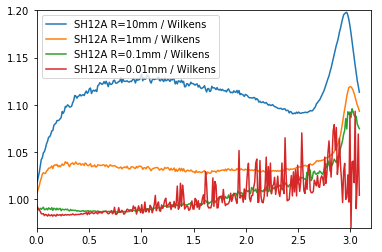

In [7]:
plt.plot(l1[:,0],l1[:,1]/dlet_keV_um, label="SH12A R=10mm / Wilkens")
plt.plot(l2[:,0],l2[:,1]/dlet_keV_um, label="SH12A R=1mm / Wilkens")
plt.plot(l3[:,0],l3[:,1]/dlet_keV_um, label="SH12A R=0.1mm / Wilkens")
plt.plot(l4[:,0],l4[:,1]/dlet_keV_um, label="SH12A R=0.01mm / Wilkens")
plt.ylim(0.97,1.2)
plt.xlim(0,3.2)
plt.legend(loc=0)

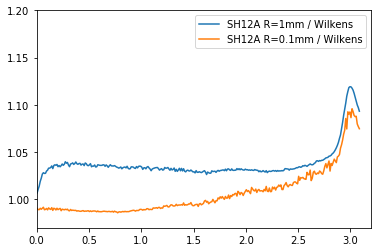

In [8]:
#plt.plot(l1[:,0],l1[:,1]/dlet_keV_um, label="SH12A R=10mm / Wilkens")
plt.plot(l2[:,0],l2[:,1]/dlet_keV_um, label="SH12A R=1mm / Wilkens")
plt.plot(l3[:,0],l3[:,1]/dlet_keV_um, label="SH12A R=0.1mm / Wilkens")
plt.ylim(0.97,1.2)
plt.xlim(0,3.2)
plt.legend(loc=0)

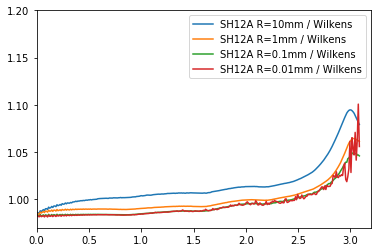

In [9]:
plt.plot(t1[:,0],t1[:,1]/tlet_keV_um, label="SH12A R=10mm / Wilkens")
plt.plot(t2[:,0],t2[:,1]/tlet_keV_um, label="SH12A R=1mm / Wilkens")
plt.plot(t3[:,0],t3[:,1]/tlet_keV_um, label="SH12A R=0.1mm / Wilkens")
plt.plot(t4[:,0],t4[:,1]/tlet_keV_um, label="SH12A R=0.01mm / Wilkens")
plt.ylim(0.97,1.2)
plt.xlim(0,3.2)
plt.legend(loc=0)

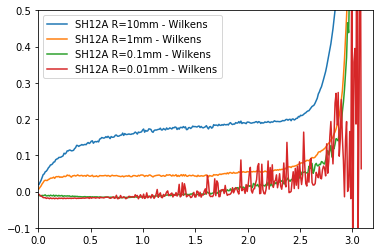

In [10]:
plt.plot(l1[:,0],l1[:,1]-dlet_keV_um, label="SH12A R=10mm - Wilkens")
plt.plot(l2[:,0],l2[:,1]-dlet_keV_um, label="SH12A R=1mm - Wilkens")
plt.plot(l3[:,0],l3[:,1]-dlet_keV_um, label="SH12A R=0.1mm - Wilkens")
plt.plot(l4[:,0],l4[:,1]-dlet_keV_um, label="SH12A R=0.01mm - Wilkens")
plt.ylim(-0.1,0.5)
plt.xlim(0,3.2)
plt.legend(loc=0)

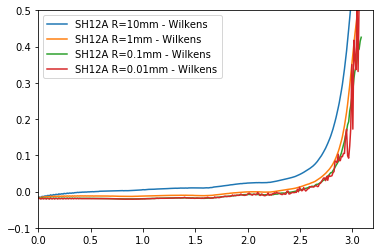

In [11]:
plt.plot(t1[:,0],t1[:,1]-tlet_keV_um, label="SH12A R=10mm - Wilkens")
plt.plot(t2[:,0],t2[:,1]-tlet_keV_um, label="SH12A R=1mm - Wilkens")
plt.plot(t3[:,0],t3[:,1]-tlet_keV_um, label="SH12A R=0.1mm - Wilkens")
plt.plot(t4[:,0],t4[:,1]-tlet_keV_um, label="SH12A R=0.01mm - Wilkens")
plt.ylim(-0.1,0.5)
plt.xlim(0,3.2)
plt.legend(loc=0)

### Broad beam simulation

 - Disc-like source in vacuum with radius 2mm
 - Rest of settings as in pencil beam

In [12]:
# let's load SH12A data
b1 = np.loadtxt("broad/let_cyl1.dat")
b2 = np.loadtxt("broad/let_cyl0p1.dat")
b3 = np.loadtxt("broad/let_cyl0p01.dat")
b4 = np.loadtxt("broad/let_cyl0p001.dat")

In [13]:
# plt.plot(b1[:,0], let_keV_um, label="Wilkens")
# plt.plot(b1[:,0],b1[:,1], label="SH12A R=10mm")
# plt.plot(b2[:,0],b2[:,1], label="SH12A R=1mm")
# plt.plot(b3[:,0],b3[:,1], label="SH12A R=0.1mm")
# plt.plot(b4[:,0],b4[:,1], label="SH12A R=0.01mm")
# plt.xlabel("Depth [cm]")
# plt.ylabel("dLETp [keV/um]")
# plt.ylim(0,20)
# plt.xlim(0,3.2)
# plt.legend(loc=0)

In [14]:
# plt.plot(b1[:,0],b1[:,1]/let_keV_um, label="SH12A R=10mm / Wilkens")
# plt.plot(b2[:,0],b2[:,1]/let_keV_um, label="SH12A R=1mm / Wilkens")
# plt.plot(b3[:,0],b3[:,1]/let_keV_um, label="SH12A R=0.1mm / Wilkens")
# plt.plot(b4[:,0],b4[:,1]/let_keV_um, label="SH12A R=0.01mm / Wilkens")
# plt.ylim(0.97,1.2)
# plt.xlim(0,3.2)
# plt.legend(loc=0)

In [15]:
# plt.plot(b1[:,0],b1[:,1]-let_keV_um, label="SH12A R=10mm - Wilkens")
# plt.plot(b2[:,0],b2[:,1]-let_keV_um, label="SH12A R=1mm - Wilkens")
# plt.plot(b3[:,0],b3[:,1]-let_keV_um, label="SH12A R=0.1mm - Wilkens")
# plt.plot(b4[:,0],b4[:,1]-let_keV_um, label="SH12A R=0.01mm - Wilkens")
# plt.ylim(-0.1,0.5)
# plt.xlim(0,3.2)
# plt.legend(loc=0)

NameError: name 'let_keV_um' is not defined

## SHIELD-HIT12A configuration

In [ ]:
!cat beam.dat

In [ ]:
!cat detect.dat

In [ ]:
!cat mat.dat

In [ ]:
!cat geo.dat